# LOESS implementation
Stefan/Yuzhao Heng
Since Sun. Nov. 21st, 2021


The ECG denoising process in paper *Optimal Multi-Stage Arrhythmia Classification Approach*,
had [implementations in MATLAB](https://github.com/zheng120/ECGDenoisingTool/blob/master/MATLABCode/ECGDenosing.m):
```matlab
    OrigECG  = DataFile(:,j);
    Fs=500;
    fp=50;fs=60;
    rp=1;rs=2.5;
    wp=fp/(Fs/2);ws=fs/(Fs/2);
    [n,wn]=buttord(wp,ws,rp,rs);
    [bz,az] = butter(n,wn);
    LPassDataFile=filtfilt(bz,az,OrigECG);

    t = 1:length(LPassDataFile);
    yy2 = smooth(t,LPassDataFile,0.1,'rloess');
    BWRemoveDataFile = (LPassDataFile-yy2);
    Dl1=BWRemoveDataFile;
    for k=2:length(Dl1)-1
        Dl1(k)=(2*Dl1(k)-Dl1(k-1)-Dl1(k+1))/sqrt(6);
    end
    NoisSTD = 1.4826*median(abs(Dl1-median(Dl1)));
    DenoisingData(:,j)= NLM_1dDarbon(BWRemoveDataFile,(1.5)*(NoisSTD),5000,10);
```

Looking for python equivalent, treating MATLAB output as ground truth


## Setup



ic| fnm: '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Chapman-Shaoxing/ECGData/MUSE_20180111_163412_52000.csv'
    fnm_stem: 'MUSE_20180111_163412_52000'
ic| dbg_path: '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Chapman-Shaoxing/my_denoise_debugging'
ic| len(df): 5000
ic| df_de.head(6):         0        1        2        3       4        5       6       7   \
                   0  541.220  665.350  124.790 -602.710  206.09  396.500 -979.12 -1774.4   
                   1  427.810  392.100  -35.046 -409.670  229.83  179.740 -894.98 -1697.0   
                   2  318.830  138.640 -179.530 -228.710  248.03  -19.352 -808.46 -1602.8   
                   3  219.400  -76.361 -295.120  -71.727  256.44 -184.660 -717.97 -1478.5   
                   4  134.850 -237.560 -371.770   50.979  252.71 -303.560 -623.45 -1318.3   
                   5   69.024 -336.260 -404.660  133.130  236.41 -369.360 -526.20 -1125.1   
                   
                       

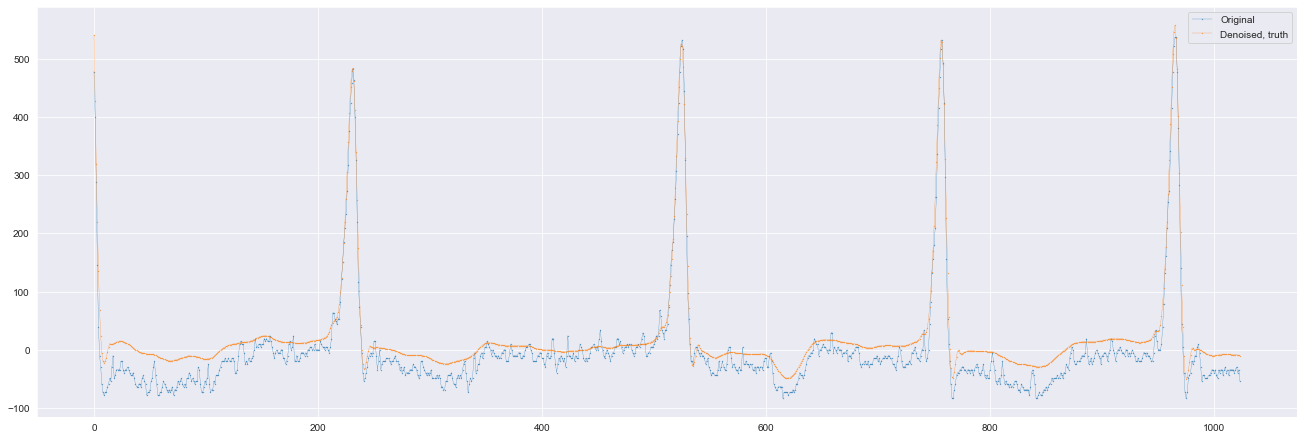

In [8]:
import os

from math import ceil
import statistics

import numpy as np
from scipy import linalg
import statsmodels.api as sm
from loess import loess_1d

from util import *
from data_preprocessor import DataPreprocessor


# dnm = 'CHAP_SHAO'
# fnm = get_rec_paths(dnm)[77]
# fnm_stem = stem(fnm)
# # '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Chapman-Shaoxing/my_denoise_debugging'
# DBG_PATH = os.path.join(PATH_BASE, DIR_DSET, config(f'{DIR_DSET}.{dnm}.dir_nm'), 'my_denoise_debugging')
# ic(fnm, fnm_stem)
# ic(DBG_PATH)
#
# df = pd.read_csv(fnm)
# df_de = pd.read_csv(fnm.replace('ECGData', 'ECGDataDenoised'), header=None)
# ic(len(df))
# ic(df_de.head(6))
# ic(df_de.iloc[:6, 0])
#
# s = df.iloc[:]['I']
# plot_1d([s, df_de.iloc[:, 0]], label=['Original', 'Denoised, truth'], title=f'{fnm_stem}, Lead I', e=2**10)

s, truth_denoised, truth_lowpass, truth_rloess, truth_localres, truth_after2nd = get_nlm_denoise_truth(verbose=True)
plot_1d([s, truth_denoised], label=['Original', 'Denoised, truth'], e=2 ** 10)

dp = DataPreprocessor()



## Low-pass filtering above 50Hz



ic| lowpass[:5]: array([478.19582438, 367.36159583, 258.58503957, 156.89593544,
                         69.7458612 ])
    truth_lowpass[:5]: array([478.23 , 367.64 , 258.86 , 156.9  ,  69.447])


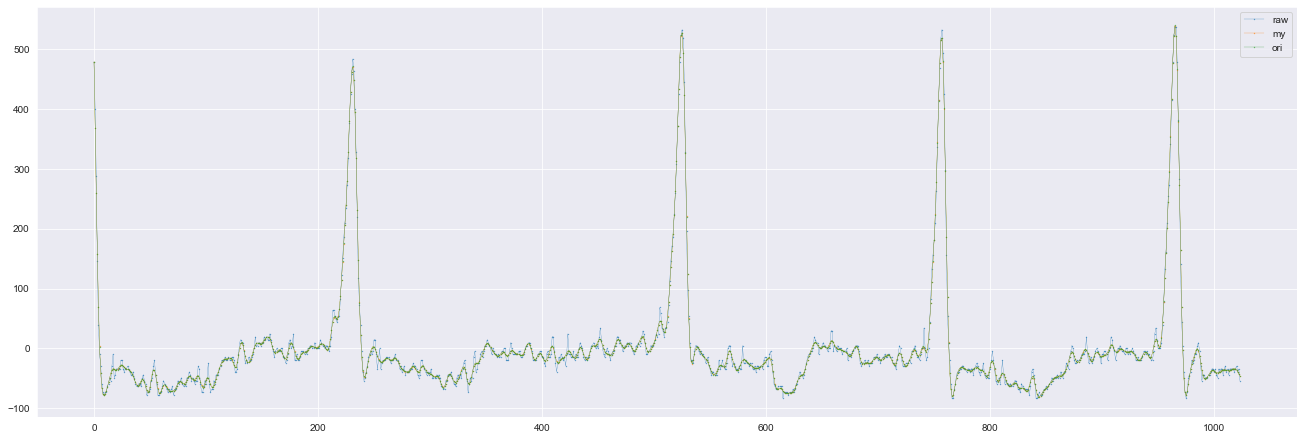

In [2]:
# fnm_lowpass = os.path.join(DBG_PATH, f'{fnm_stem}, lowpass.csv')
# truth_lowpass = pd.read_csv(fnm_lowpass, header=None).iloc[:, 0].to_numpy()


lowpass = dp.butterworth_low_pass(s)
ic(lowpass[:5], truth_lowpass[:5])
plot_1d([s, lowpass, truth_lowpass], label=['raw', 'my', 'ori'], e=2**10)
assert np.allclose(lowpass, truth_lowpass, atol=1)



## Baseline wander removal with LOESS
LOESS for smoothing, docs from MATLAB implementation
```matlab
%   Z = SMOOTH(Y,SPAN,METHOD) smooths data Y with specified METHOD. The
%   available methods are:
%
%           'moving'   - Moving average (default)
%           'lowess'   - Lowess (linear fit)
%           'loess'    - Loess (quadratic fit)
%           'sgolay'   - Savitzky-Golay
%           'rlowess'  - Robust Lowess (linear fit)
%           'rloess'   - Robust Loess (quadratic fit)
```
```matlab
% The difference between LOWESS and LOESS is that LOWESS uses a
% linear model to do the local fitting whereas LOESS uses a
% quadratic model to do the local fitting. Some other software
% may not have LOWESS, instead, they use LOESS with order 1 or 2 to
% represent these two smoothing methods.
```

Don't see a good python implementation, and the result doesn't match well...



### Implementations



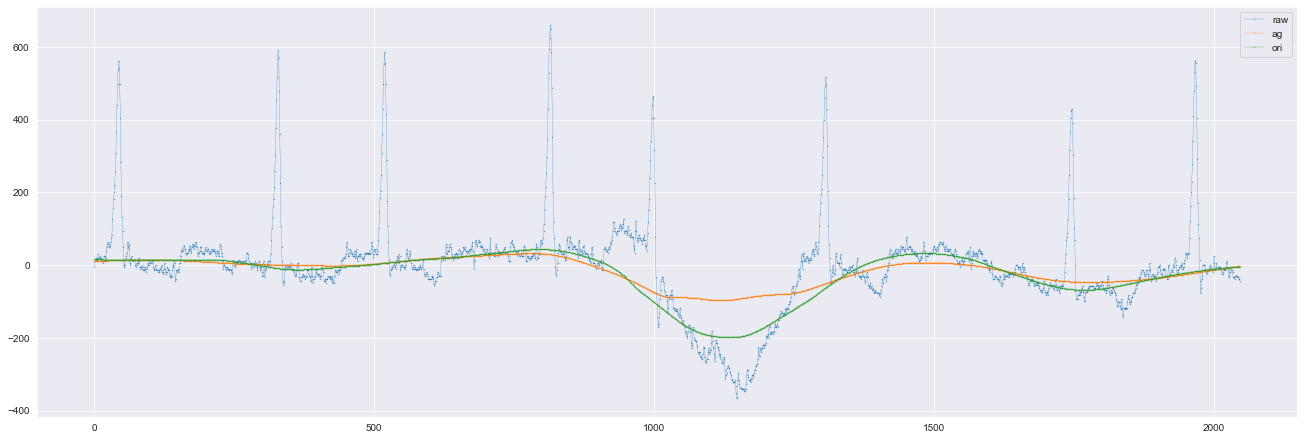

ic| diff.min(): -25.546538568536615
    diff.mean(): 3.5763059854541726
    np.median(diff): 0.18009113880586924
    diff.max(): 104.80927723263451


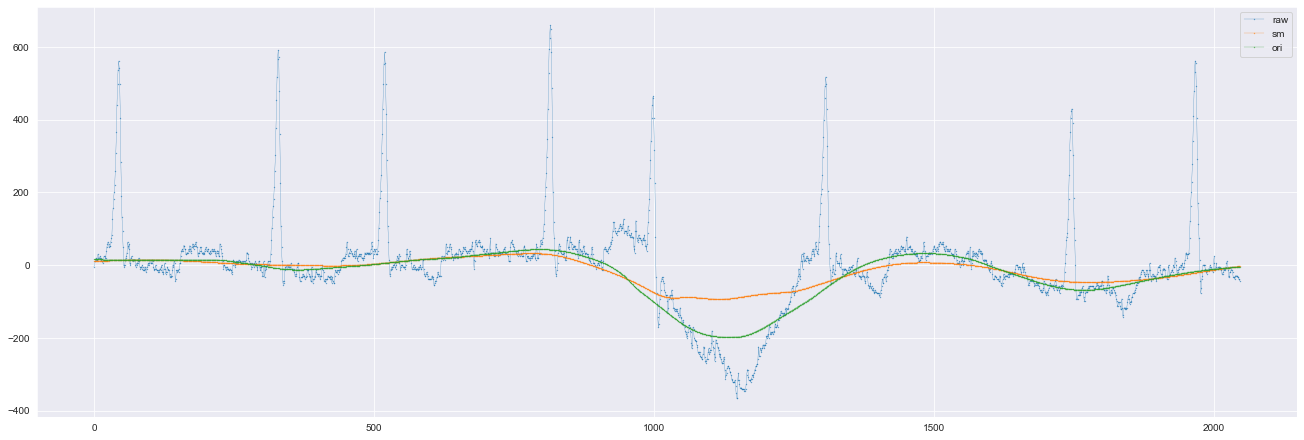

ic| diff.min(): -25.395210775805833
    diff.mean(): 3.8013187473166696
    np.median(diff): 0.16240725918668542
    diff.max(): 108.53229540914334


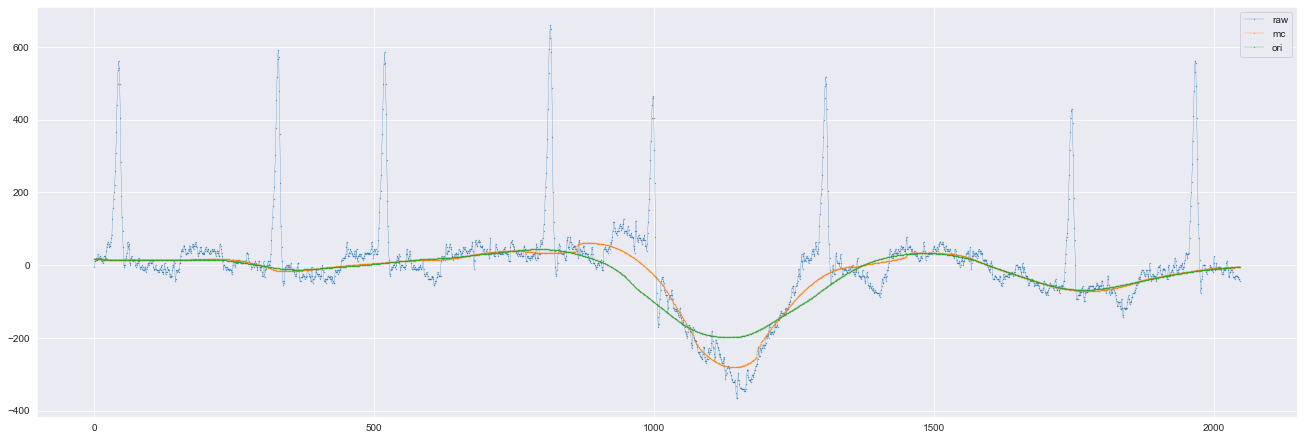

ic| diff.min(): -84.02328223556279
    diff.mean(): 0.8301827096713943
    np.median(diff): -0.11427537004697985
    diff.max(): 78.84072763007292


In [10]:
# fnm_rloess = os.path.join(DBG_PATH, f'{fnm_stem}, rloess.csv')
# truth_rloess = pd.read_csv(fnm_rloess, header=None).iloc[:, 0].to_numpy()


def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest

    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.

    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    """
    This module implements the Lowess function for nonparametric regression.

    Functions:
    lowess Fit a smooth nonparametric regression curve to a scatterplot.

    For more information, see

    William S. Cleveland: "Robust locally weighted regression and smoothing
    scatterplots", Journal of the American Statistical Association, December 1979,
    volume 74, number 368, pp. 829-836.

    William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
    approach to regression analysis by local fitting", Journal of the American
    Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
    """
    # Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
    #
    # License: BSD (3-clause)
    #
    # Taken from https://gist.github.com/agramfort/850437
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest


def loess_test(sig, method='ag', frac=0.1, it=5):
    x = np.arange(sig.size)
    if method == 'ag':
        sig = lowess_ag(x, sig, f=frac, iter=it)
    elif method == 'sm':
        sig = sm.nonparametric.lowess(sig, x, frac=frac, it=it, return_sorted=False)
    elif method == 'mc':
        _, sig, _ = loess_1d.loess_1d(x.astype(np.float64), sig, degree=2, frac=frac)
        # _, sig, _ = loess_1d.loess_1d(np.arange(sig.size).astype(np.float64), sig, degree=2, frac=0.1)
    plot_1d([s, sig, truth_rloess], label=['raw', method, 'ori'], s=2**11, e=2**12)
    diff = sig - truth_rloess
    ic(diff.min(), diff.mean(), np.median(diff), diff.max())


def test(s_):
    loess_test(s_, method='ag')  # Looks like this approach is linear since it's called LOWESS?
    loess_test(s_, method='sm')  # Only find LOWESS, not LOESS
    # Degree 2 looks like the closest match & should be the LOESS implementation in MATLAB judging from source code
    loess_test(s_, method='mc')

# test(lowpass)
test(truth_lowpass)  # Not much difference in output



### The one picked
The ECG result looks okay - the peaks of the python implementation was actually closer to original sample compared to the MATLAB original one



ic| rloess[:5]: array([-68.93669466, -68.44426032, -67.953923  , -67.46578654,
                       -66.97985424])
    truth_rloess[:5]: array([-62.692, -62.319, -61.948, -61.578, -61.211])


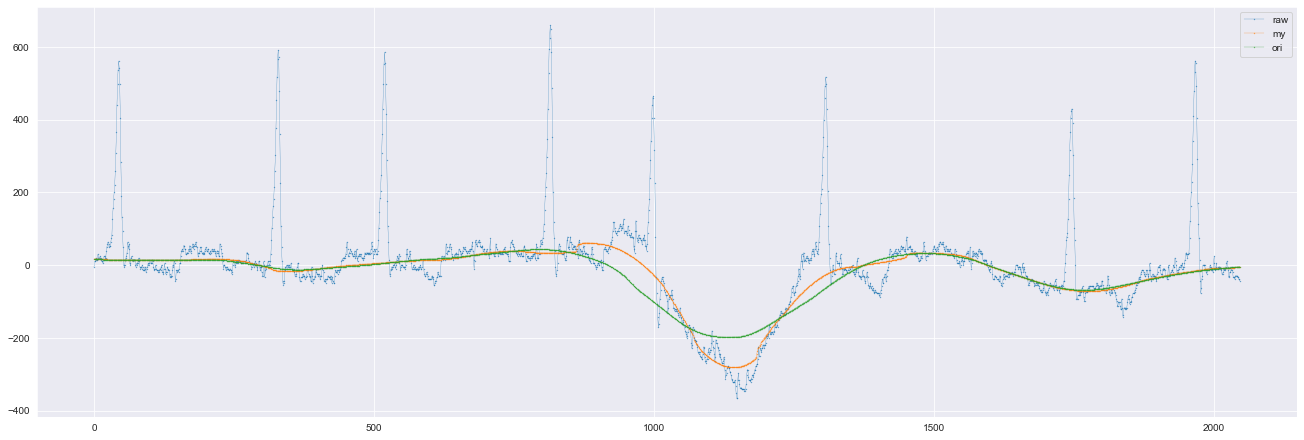

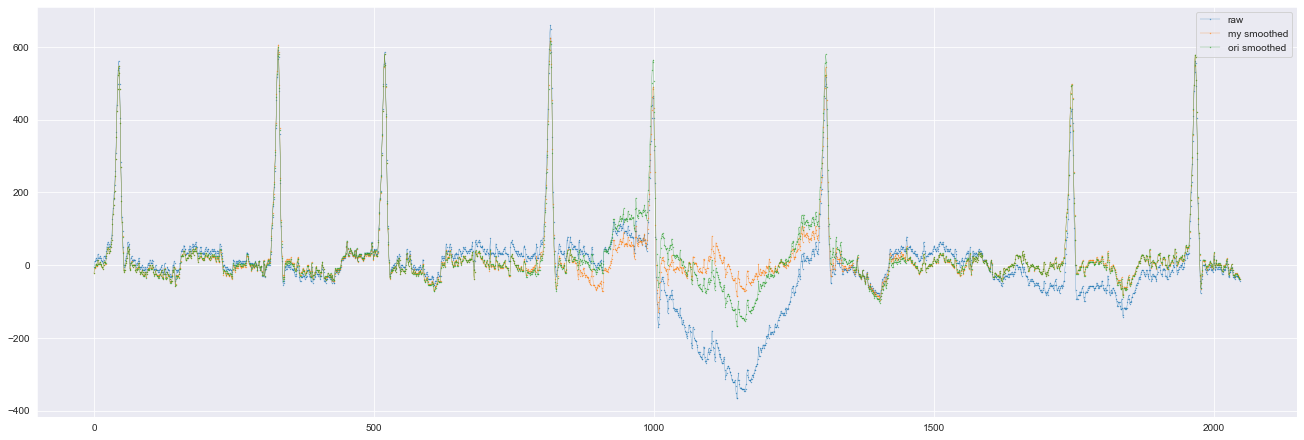

ic| np.allclose(rloess, truth_rloess, atol=10): False


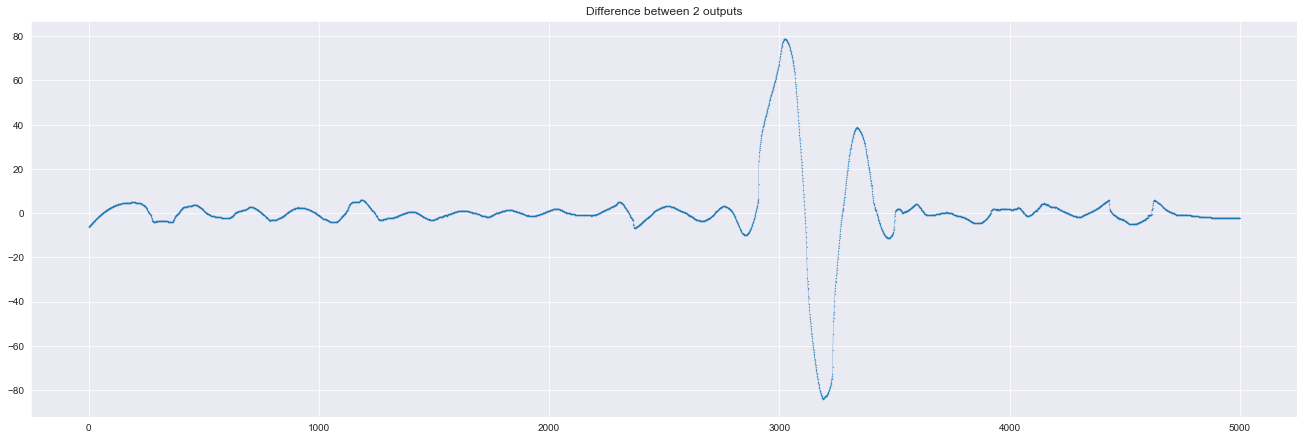

In [9]:
rloess = dp.rloess(lowpass, n=500)  # Start from previous python implementation values to simulate expected performance
# rloess = dp.rloess(truth_lowpass, n=500)
ic(rloess[:5], truth_rloess[:5])
plot_1d([s, rloess, truth_rloess], label=['raw', 'my', 'ori'], s=2**11, e=2**12)
plot_1d([s, s - rloess, s - truth_rloess], label=['raw', 'my smoothed', 'ori smoothed'], s=2**11, e=2**12)
ic(np.allclose(rloess, truth_rloess, atol=10))
plot_1d(rloess - truth_rloess, title='Difference between 2 outputs')



## Nonlocal means denoising


### Estimate standard deviation of noise


In [5]:
after_2nd = truth_lowpass - truth_rloess
assert math.isclose(dp.est_noise_std(after_2nd), 7.4435, abs_tol=1e-3)  # Value from MATLAB output



### NLM


ic| denoised[:5]: array([540.922, 429.959, 320.808, 218.478, 130.658])
    truth_denoised[:5]: array([541.22, 427.81, 318.83, 219.4 , 134.85])


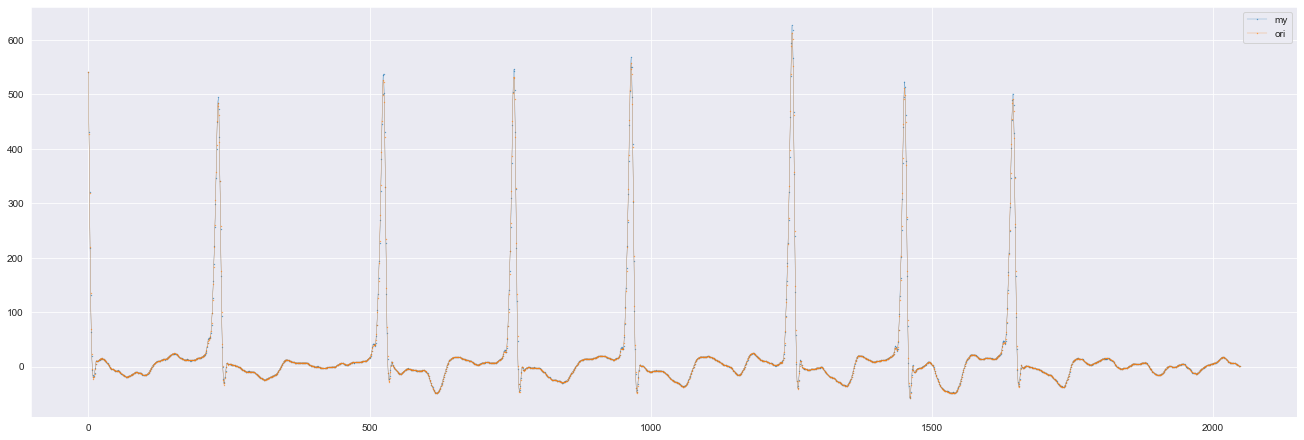

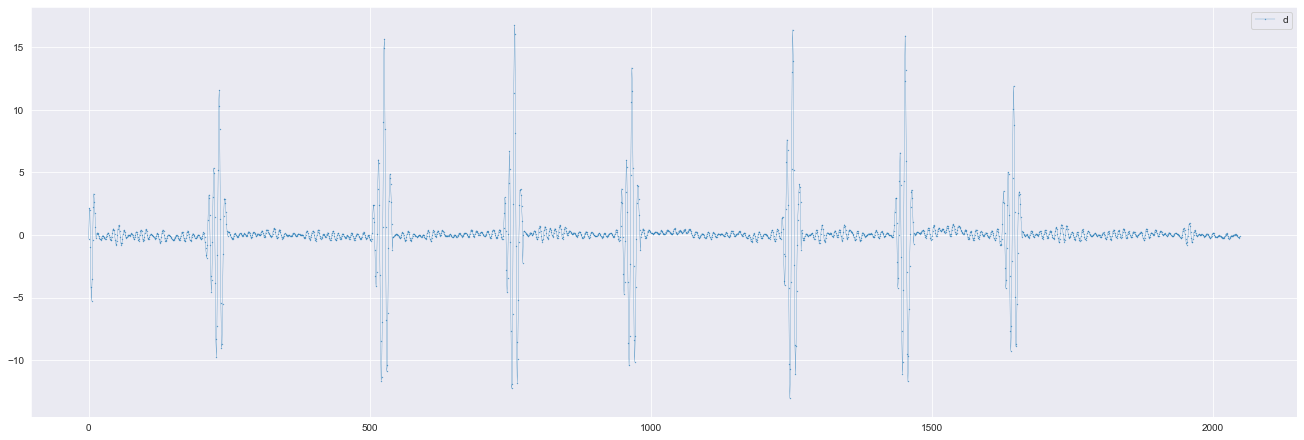

ic| np.allclose(denoised, truth_denoised, atol=10): False


False

In [7]:
denoised = dp.nlm(after_2nd, scale=1.5, sch_wd=after_2nd.size, patch_wd=10)
ic(denoised[:5], truth_denoised[:5])
plot_1d([denoised, truth_denoised], label=['my', 'ori'], e=2**11)
plot_1d(denoised-truth_denoised, label='difference', e=2**11)  # Interesting pattern tho, will not investigate why
ic(np.allclose(denoised, truth_denoised, atol=10))

